# Generate HTML from Noise

In [31]:
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import time
import math
%matplotlib inline

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np
import pickle

In [2]:
def time_since(start):
    now = time.time()
    s = now - start
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
data_path = "/Users/dhoomilbsheta/Development/datasets/pix2code_datasets/web/all_data"

epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100
img_dims = 64

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

### Preprocess Data

In [10]:
def transform(data, dims):
    data = mx.image.imresize(data, dims, dims)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [12]:
img_list = []
for fname in os.listdir(data_path):
    if not fname.endswith('.png'):
        continue
    img = os.path.join(data_path, fname)
    img_arr = mx.image.imread(img)
    img_arr = transform(img_arr, img_dims)
    img_list.append(img_arr)
        
with open("web_ui.pkl", "wb") as f:
    pickle.dump(img_list, f)

### Load Data

In [13]:
with open("web_ui.pkl", "rb") as f:
    img_list = pickle.load(f)

print(f"Total {len(img_list)} HTML pages in dataset")
print(f"Shape of data {img_list[0].shape}")

Total 1750 HTML pages in dataset
Shape of data (1, 3, 64, 64)


In [15]:
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size, shuffle=True)
print(train_data.provide_data)

[DataDesc[data,(64, 3, 64, 64),<class 'numpy.float32'>,NCHW]]


### Build the generator

In [16]:
n_channels = 3
n_filters_g = 64
generator = nn.HybridSequential()
with generator.name_scope():
    # input is Z, going into a convolution
    generator.add(nn.Conv2DTranspose(n_filters_g * 8, 4, 1, 0, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 4 x 4
    generator.add(nn.Conv2DTranspose(n_filters_g * 4, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 8 x 8
    generator.add(nn.Conv2DTranspose(n_filters_g * 2, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 16 x 16
    generator.add(nn.Conv2DTranspose(n_filters_g, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 32 x 32
    generator.add(nn.Conv2DTranspose(n_channels, 4, 2, 1, use_bias=False))
    generator.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

### Build the discriminator

In [17]:
n_filters_d = 64
discriminator = nn.HybridSequential()
with discriminator.name_scope():
    # input is (nc) x 64 x 64
    discriminator.add(nn.Conv2D(n_filters_d, 4, 2, 1, use_bias=False))
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 32 x 32
    discriminator.add(nn.Conv2D(n_filters_d * 2, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 16 x 16
    discriminator.add(nn.Conv2D(n_filters_d * 4, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 8 x 8
    discriminator.add(nn.Conv2D(n_filters_d * 8, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 4 x 4
    discriminator.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [18]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
generator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [19]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()

metric = mx.metric.CustomMetric(facc)

In [79]:
def train(epochs):
    print(f"Training for {epochs} epochs...")
    start = time.time()
    for epoch in range(epochs):
        train_data.reset()
        iteration = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

            with autograd.record():
                # train with real image
                output = discriminator(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with autograd.record():
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            if iteration % 50 == 0:
                name, acc = metric.get()
                print(f'epoch {epoch}: iter {iteration} d_loss = {nd.mean(errD).asscalar()}, generator loss = {nd.mean(errG).asscalar()}, training acc = {acc}')

            iteration = iteration + 1
        print(f"Time: {time_since(start)}")
        name, acc = metric.get()
        metric.reset()
    print(f"Time: {time_since(start)}")

In [80]:
train(epochs)

Training for 10 epochs...
epoch 0: iter 0 d_loss = 5.843017578125, generator loss = 9.334108352661133, training acc = 0.5102040816326531
Time: 3m 43s
epoch 1: iter 0 d_loss = 0.16916681826114655, generator loss = 4.2723798751831055, training acc = 0.96875
Time: 7m 41s
epoch 2: iter 0 d_loss = 0.14750060439109802, generator loss = 4.6279120445251465, training acc = 1.0
Time: 11m 29s
epoch 3: iter 0 d_loss = 0.28419414162635803, generator loss = 2.9573769569396973, training acc = 0.90625
Time: 15m 21s
epoch 4: iter 0 d_loss = 4.858837604522705, generator loss = 3.586796998977661, training acc = 0.5234375
Time: 19m 9s
epoch 5: iter 0 d_loss = 1.2222366333007812, generator loss = 12.093986511230469, training acc = 0.703125
Time: 22m 56s
epoch 6: iter 0 d_loss = 0.1153346449136734, generator loss = 4.975555419921875, training acc = 1.0
Time: 26m 45s
epoch 7: iter 0 d_loss = 0.07760730385780334, generator loss = 5.066558361053467, training acc = 1.0
Time: 30m 33s
epoch 8: iter 0 d_loss = 0.3

In [83]:
generator.save_params(filename="dcgan_g")
discriminator.save_params(filename="dcgan_d")

In [84]:
generator.load_params(filename="dcgan_g", ctx=ctx)
discriminator.load_params(filename="dcgan_d", ctx=ctx)

In [85]:
plt.figure(figsize=(20,20))

def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

In [86]:
def vis():
    plt.figure(figsize=(20,20))
    num_image = 12
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    step = 0.05
    for i in range(num_image):
        img = generator(latent_z)
        plt.subplot(3,4,i+1)
        visualize(img[0])
        latent_z += 0.05
    plt.show()

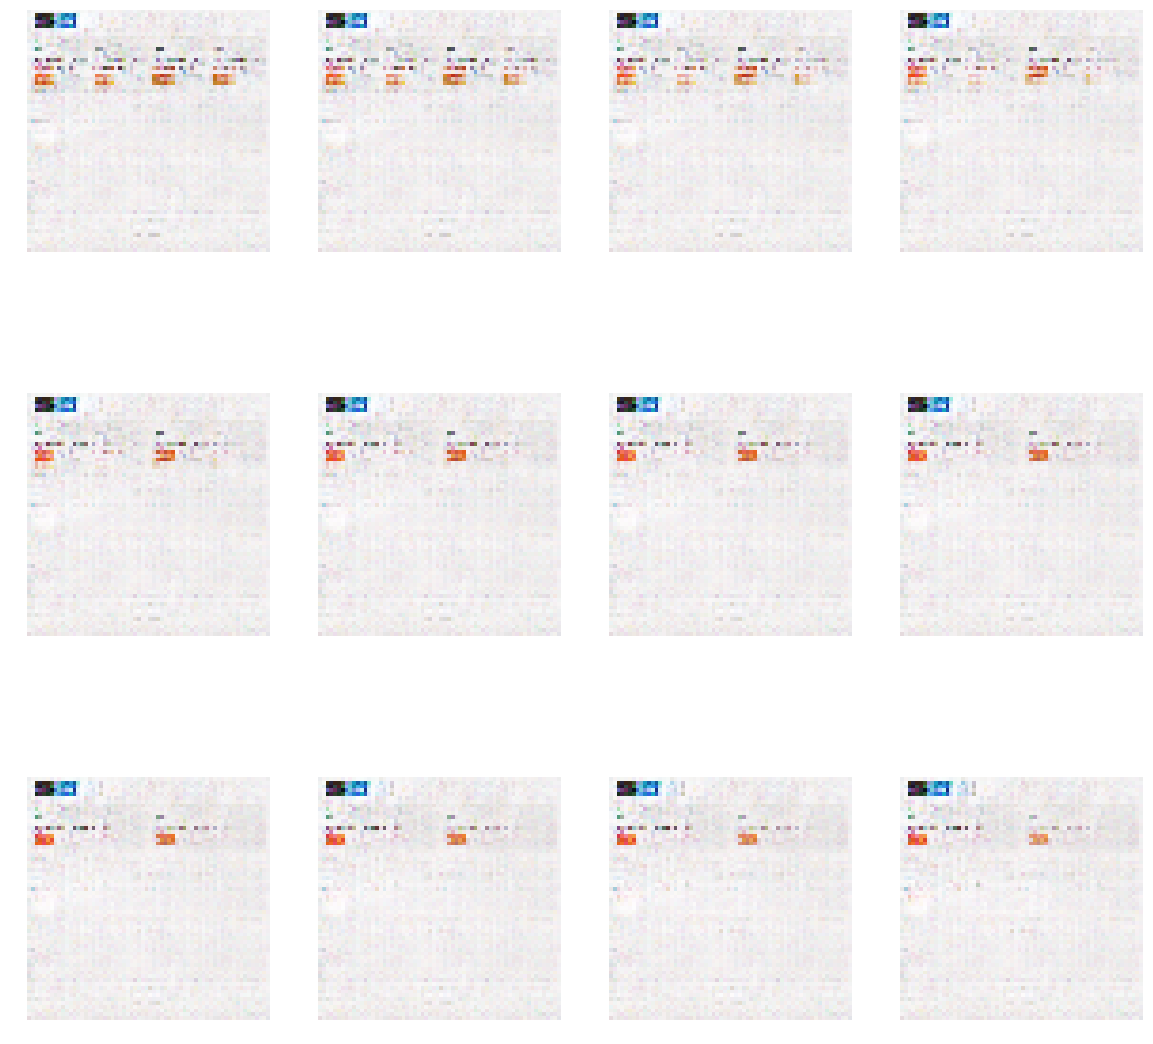

In [90]:
vis()